# NestedFields


In some applications, you may have access to different fields that each cover only part of the region of interest. Then, you would like to combine them all together. You may also have a field covering the entire region and another one only covering part of it, but with a higher resolution. The set of those fields form what we call nested fields.

It is possible to combine all those fields with kernels, either with different if/else statements depending on particle position, or using recovery kernels (if only two levels of nested fields).

However, an easier way to work with nested fields in Parcels is to combine all those fields into one `NestedField` object. The Parcels code will then try to successively interpolate the different fields.

For each Particle, the algorithm is the following:

1. Interpolate the particle onto the first `Field` in the `NestedFields` list.

2. If the interpolation succeeds or if an error other than `ErrorOutOfBounds` is thrown, the function is stopped.

3. If an `ErrorOutOfBounds` is thrown, try step 1) again with the next `Field` in the `NestedFields` list

4. If interpolation on the last `Field` in the `NestedFields` list also returns an `ErrorOutOfBounds`, then the Particle is flagged as OutOfBounds.

This algorithm means that **the order of the fields in the 'NestedField' matters**. In particular, the smallest/finest resolution fields have to be listed _before_ the larger/coarser resolution fields.

Note also that `pset.execute()` can be _much_ slower on `NestedField` objects than on normal `Fields`. This is because the handling of the `ErrorOutOfBounds` (step 3) happens outside the fast inner-JIT-loop in C; but instead is delt with in the slower python loop around it. This means that especially in cases where particles often move from one nest to another, simulations can become very slow.

This tutorial shows how to use these `NestedField` with a very idealised example.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from parcels import (
    AdvectionRK4,
    Field,
    FieldSet,
    JITParticle,
    NestedField,
    ParticleSet,
)

First define a zonal and meridional velocity field defined on a high resolution (dx = 100m) 2kmx2km grid with a flat mesh. The zonal velocity is uniform and 1 m/s, and the meridional velocity is equal to 0.5 _ cos(lon / 200 _ pi / 2) m/s.


In [2]:
dim = 21
lon = np.linspace(0.0, 2e3, dim, dtype=np.float32)
lat = np.linspace(0.0, 2e3, dim, dtype=np.float32)
lon_g, lat_g = np.meshgrid(lon, lat)
V1_data = np.cos(lon_g / 200 * np.pi / 2)
U1 = Field("U1", np.ones((dim, dim), dtype=np.float32), lon=lon, lat=lat)
V1 = Field("V1", V1_data, grid=U1.grid)

Now define the same velocity field on a low resolution (dx = 2km) 20kmx4km grid.


In [3]:
xdim = 11
ydim = 3
lon = np.linspace(-2e3, 18e3, xdim, dtype=np.float32)
lat = np.linspace(-1e3, 3e3, ydim, dtype=np.float32)
lon_g, lat_g = np.meshgrid(lon, lat)
V2_data = np.cos(lon_g / 200 * np.pi / 2)
U2 = Field("U2", np.ones((ydim, xdim), dtype=np.float32), lon=lon, lat=lat)
V2 = Field("V2", V2_data, grid=U2.grid)

We now combine those fields into a `NestedField` and create the fieldset


In [4]:
U = NestedField("U", [U1, U2])
V = NestedField("V", [V1, V2])
fieldset = FieldSet(U, V)

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /var/folders/x0/1qxj679n55zcybylvdsb4bxh0000gq/T/parcels-503/1d300f4460ae7e35374442784586c2b4_0.c


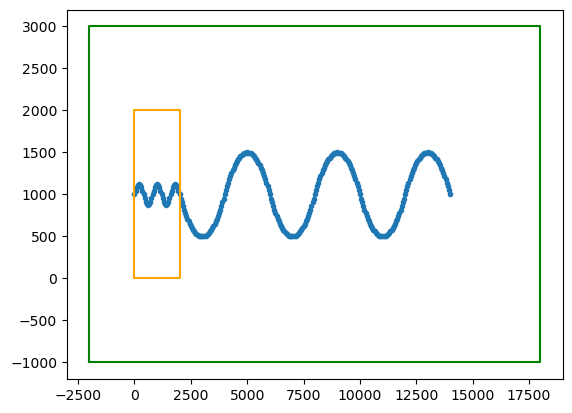

In [5]:
pset = ParticleSet(fieldset, pclass=JITParticle, lon=[0], lat=[1000])

output_file = pset.ParticleFile(
    name="NestedFieldParticle.zarr", 
    outputdt=50,
    chunks = (1, 100)
)

pset.execute(AdvectionRK4, 
             runtime=14000, 
             dt=10, 
             output_file=output_file
)

ds = xr.open_zarr("NestedFieldParticle.zarr")
plt.plot(ds.lon.T, ds.lat.T, '.-')
plt.plot([0, 2e3, 2e3, 0, 0], [0, 0, 2e3, 2e3, 0], c="orange")
plt.plot([-2e3, 18e3, 18e3, -2e3, -2e3], [-1e3, -1e3, 3e3, 3e3, -1e3], c="green");

As we observe, there is a change of dynamic at lon=2000, which corresponds to the change of grid.

The analytical solution to the problem:

\begin{align}
dx/dt &= 1;\\
dy/dt &= \cos(x \pi/400);\\
\text{with } x(0) &= 0, y(0) = 1000
\end{align}

is

\begin{align}
x(t) &= t;\\
y(t) &= 1000 + 400/\pi \sin(t \pi / 400)
\end{align}

which is captured by the High Resolution field (orange area) but not the Low Resolution one (green area).


## Keep track of the field interpolated

For different reasons, you may want to keep track of the field you have interpolated. You can do that easily by creating another field that share the grid with original fields.
Watch out that this operation has a cost of a full interpolation operation.


In [6]:
# Need to redefine fieldset
fieldset = FieldSet(U, V)

ones_array1 = np.ones((U1.grid.ydim, U1.grid.xdim), dtype=np.float32)
F1 = Field("F1", ones_array1, grid=U1.grid)

ones_array2 = np.ones((U2.grid.ydim, U2.grid.xdim), dtype=np.float32)
F2 = Field("F2", 2 * ones_array2, grid=U2.grid)

F = NestedField("F", [F1, F2])
fieldset.add_field(F)

In [7]:
from parcels import Variable


def SampleNestedFieldIndex(particle, fieldset, time):
    particle.f = fieldset.F[time, particle.depth, particle.lat, particle.lon]


class SampleParticle(JITParticle):
    f = Variable("f", dtype=np.int32)


pset = ParticleSet(fieldset, pclass=SampleParticle, lon=[1000], lat=[500])
pset.execute(SampleNestedFieldIndex, runtime=0, dt=0)
print(
    f"Particle ({pset[0].lon:g}, {pset[0].lat:g}) "
    f"interpolates Field #{int(pset[0].f)}"
)

pset[0].lon = 10000
pset.execute(SampleNestedFieldIndex, runtime=0, dt=0)
print(
    f"Particle ({pset[0].lon:g}, {pset[0].lat:g}) "
    f"interpolates Field #{int(pset[0].f)}"
)

INFO: Compiled ArraySampleParticleSampleNestedFieldIndex ==> /var/folders/x0/1qxj679n55zcybylvdsb4bxh0000gq/T/parcels-503/cfcc02c9b58549fc53db33ce55eeb948_0.c
Particle (1000, 500) interpolates Field #1
Particle (10000, 500) interpolates Field #2
